In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Fourier Layer
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x, dim=-1)

        # Apply spectral weights
        out_ft = torch.zeros_like(x_ft, dtype=torch.cfloat)
        out_ft[..., :self.modes] = torch.einsum("bix,iox->box", x_ft[..., :self.modes], self.weights)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        return x

In [4]:
#Fno1d model
class FNO1D(nn.Module):
    def __init__(self, modes, width):
        super(FNO1D, self).__init__()
        self.modes = modes
        self.width = width

        self.fc0 = nn.Linear(2, self.width)  # Input layer

        self.spectral_conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.spectral_conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.spectral_conv3 = SpectralConv1d(self.width, self.width, self.modes)

        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.spectral_conv1(x)
        x2 = self.w1(x)
        x = x1 + x2

        x1 = self.spectral_conv2(x)
        x2 = self.w2(x)
        x = x1 + x2

        x1 = self.spectral_conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [5]:
def generate_data(n_samples, n_points, start=0, end=2*np.pi):
    x = np.linspace(start, end, n_points)
    y = 10 * np.sin(4 * x) + 1* np.sin(15*x)
    x = np.expand_dims(x, axis=0).repeat(n_samples, axis=0)
    y = np.expand_dims(y, axis=0).repeat(n_samples, axis=0)
    return x, y

In [6]:
n_train, n_test, n_points = 100, 10, 500
x, y = generate_data(n_train + n_test, n_points)

In [7]:
x_train, y_train = x[:n_train], y[:n_train]
x_test, y_test = x[n_train:], y[n_train:]

x_train = torch.tensor(x_train, dtype=torch.float32).cuda()
y_train = torch.tensor(y_train, dtype=torch.float32).cuda()

x_test = torch.tensor(x_test, dtype=torch.float32).cuda()
y_test = torch.tensor(y_test, dtype=torch.float32).cuda()

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([100, 500]),
 torch.Size([100, 500]),
 torch.Size([10, 500]),
 torch.Size([10, 500]))

In [9]:
model = FNO1D(modes=16, width=64).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
def train(model, x_train, y_train, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        inputs = torch.stack((x_train, x_train), dim=-1)  # Combine x with itself for input
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

In [11]:
train(model, x_train, y_train, n_epochs=200)

Epoch 0, Loss: 50.471638
Epoch 10, Loss: 29.544510
Epoch 20, Loss: 4.592355
Epoch 30, Loss: 1.239140
Epoch 40, Loss: 0.402116
Epoch 50, Loss: 0.120741
Epoch 60, Loss: 0.058237
Epoch 70, Loss: 0.031510
Epoch 80, Loss: 0.019224
Epoch 90, Loss: 0.012856
Epoch 100, Loss: 0.009296
Epoch 110, Loss: 0.006941
Epoch 120, Loss: 0.005304
Epoch 130, Loss: 0.004114
Epoch 140, Loss: 0.003236
Epoch 150, Loss: 0.002575
Epoch 160, Loss: 0.002058
Epoch 170, Loss: 0.001665
Epoch 180, Loss: 0.001355
Epoch 190, Loss: 0.001120


In [12]:
def test(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.stack((x_test, x_test), dim=-1)  # Combine x with itself for input
        predictions = model(inputs).squeeze()
        test_loss = criterion(predictions, y_test)
        print(f"Test Loss: {test_loss.item():.6f}")
    return predictions

In [13]:
predictions = test(model, x_test, y_test)

Test Loss: 0.000935


In [17]:
predictions.shape, x_test.shape, y_test.shape

(torch.Size([10, 500]), torch.Size([10, 500]), torch.Size([10, 500]))

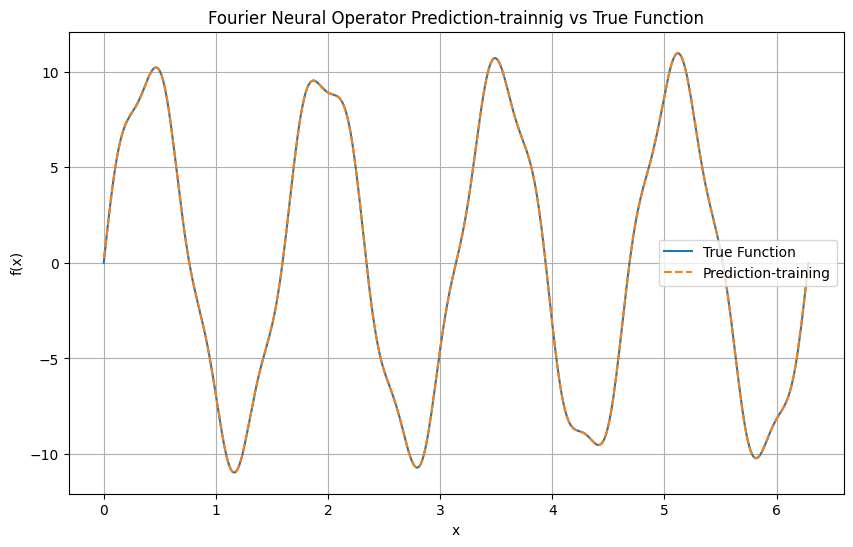

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(x_test[0].cpu().numpy(), y_test[0].cpu().numpy(), label='True Function', )
plt.plot(x_test[0].cpu().numpy(), predictions[0].cpu().numpy(), label='Prediction-training', linestyle='--')
plt.legend()
plt.title("Fourier Neural Operator Prediction-trainnig vs True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

In [44]:
# Test on new points between 2*pi and 4*pi
x_new, y_new = generate_data(1, 2048, start= 2.5*np.pi, end=4.5* np.pi) 
x_new = torch.tensor(x_new, dtype=torch.float32).cuda()
y_new = torch.tensor(y_new, dtype=torch.float32).cuda()
predictions_new = test(model, x_new, y_new)

Test Loss: 24.161976


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 2048])) that is different to the input size (torch.Size([2048])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [45]:
predictions_new_n=predictions_new.unsqueeze(0)
predictions_new_n.shape, x_new.shape, y_new.shape

(torch.Size([1, 2048]), torch.Size([1, 2048]), torch.Size([1, 2048]))

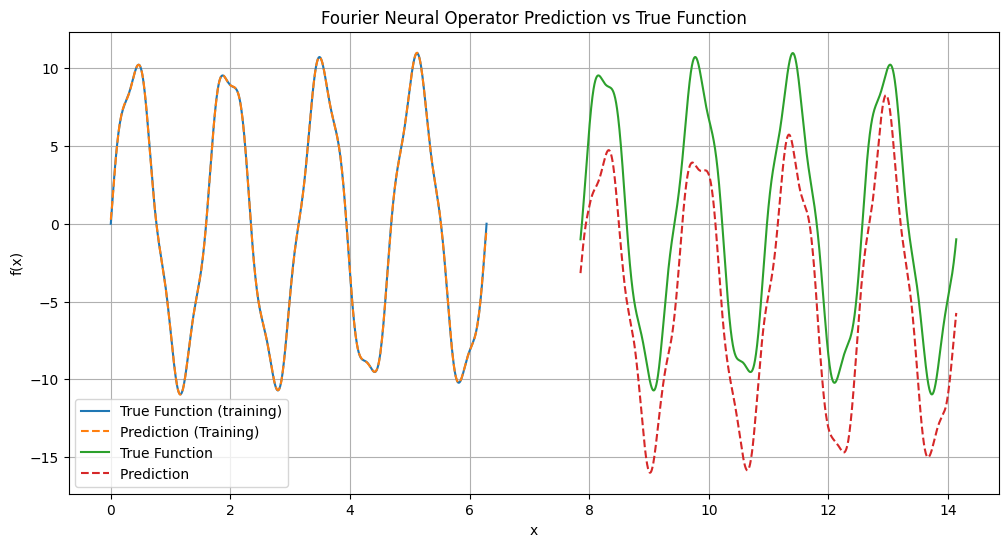

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(x_test[0].cpu().numpy(), y_test[0].cpu().numpy(), label='True Function (training)')
plt.plot(x_test[0].cpu().numpy(), predictions[0].cpu().numpy(), label='Prediction (Training)', linestyle='--')
plt.plot(x_new[0].cpu().numpy(), y_new[0].cpu().numpy(), label='True Function ')
plt.plot(x_new[0].cpu().numpy(), predictions_new_n[0].cpu().numpy(), label='Prediction ', linestyle='--')
plt.legend()
plt.title("Fourier Neural Operator Prediction vs True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()